#### Forecasting Sales of Conventional Avocato In California
####### Original dataset https://www.kaggle.com/alanluo418/avocado-prices-20152019?select=Avocado.csv
####### Data from 2015 to 2019, per week
####### Thanks to article https://towardsdatascience.com/how-to-forecast-sales-with-python-using-sarima-model-ba600992fa7d

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'

In [2]:
# Reading Dataset
df = pd.read_excel('C:/Users/mcter/avocato_conventional_ca.xlsx')
df.columns=['Date','Sales']

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.index = pd.DatetimeIndex(df.index).to_period('W')
df.head()

,Sales
Date,
2014-12-29/2015-01-04,5.372921e+06
2015-01-05/2015-01-11,5.542938e+06
2015-01-12/2015-01-18,5.682334e+06
2015-01-19/2015-01-25,5.225677e+06
2015-01-26/2015-02-01,7.677354e+06


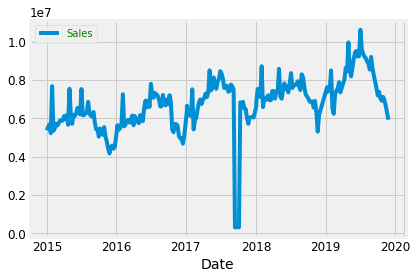

In [3]:
df.plot()

####### There is a huge drop for few weeks in 2017. It looks like an error in the dataset. 
####### It may create a lot of noise in the forecast.

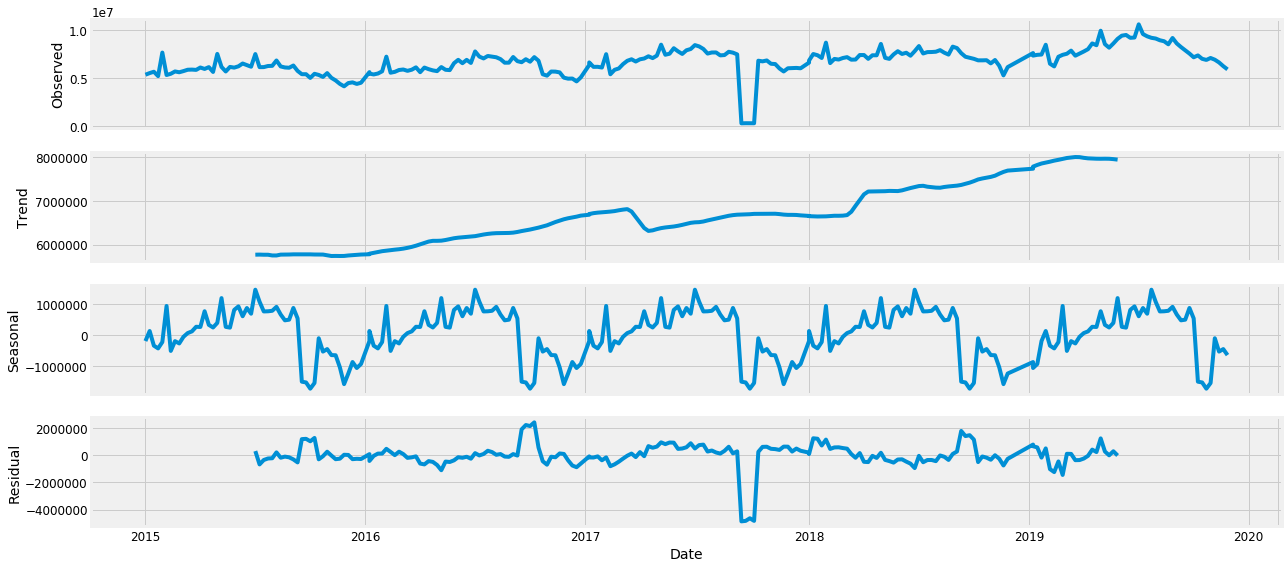

In [4]:
# Decomposing the timeseries
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df, model='additive', freq=52) # there are 52 weeks in one year
fig = decomposition.plot()
plt.show()


In [5]:
# setting values to p, d, and q
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [6]:
# Creating the models for each p, d, q combination
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}52 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('Error')
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 52)52 - AIC:8653.048416829603
ARIMA(0, 0, 0)x(0, 0, 1, 52)52 - AIC:6784.254944611622
ARIMA(0, 0, 0)x(0, 1, 0, 52)52 - AIC:6302.1793216950955
ARIMA(0, 0, 0)x(0, 1, 1, 52)52 - AIC:13043.663702876876
ARIMA(0, 0, 0)x(1, 0, 0, 52)52 - AIC:6316.683036768049
ARIMA(0, 0, 0)x(1, 0, 1, 52)52 - AIC:6273.148948927361
ARIMA(0, 0, 0)x(1, 1, 0, 52)52 - AIC:4693.274860703375
ARIMA(0, 0, 0)x(1, 1, 1, 52)52 - AIC:13381.0508907334
ARIMA(0, 0, 1)x(0, 0, 0, 52)52 - AIC:8438.23400362126
ARIMA(0, 0, 1)x(0, 0, 1, 52)52 - AIC:6664.973790486117
ARIMA(0, 0, 1)x(0, 1, 0, 52)52 - AIC:6170.52536795981
ARIMA(0, 0, 1)x(0, 1, 1, 52)52 - AIC:12994.247427969487
ARIMA(0, 0, 1)x(1, 0, 0, 52)52 - AIC:6710.919693057547
ARIMA(0, 0, 1)x(1, 0, 1, 52)52 - AIC:6645.646650273175
ARIMA(0, 0, 1)x(1, 1, 0, 52)52 - AIC:4617.924095863344
ARIMA(0, 0, 1)x(1, 1, 1, 52)52 - AIC:13331.14910247248
ARIMA(0, 1, 0)x(0, 0, 0, 52)52 - AIC:7570.1606629475045
ARIMA(0, 1, 0)x(0, 0, 1, 52)52 - AIC:6081.831458207098
ARIMA(0, 

#######  The AIC is high. We are looking for values close to zero. But let's give it a try.

In [7]:
# The lowest AIC is ARIMA(1, 1, 0)x(1, 1, 0, 52)12 - AIC:4525.414741127677
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1217      0.093     -1.309      0.191      -0.304       0.061
ar.S.L52      -0.4465      0.029    -15.256      0.000      -0.504      -0.389
sigma2      1.383e+12   3.77e-14   3.66e+25      0.000    1.38e+12    1.38e+12


In [8]:
pred = results.get_forecast(steps=4) # next 4 weeks
pred_ci = pred.conf_int()
pred_ci.head(4)

,lower Sales,upper Sales
2019-11-04/2019-11-10,3.803277e+06,8.412987e+06
2019-11-11/2019-11-17,2.503877e+06,8.639054e+06
2019-11-18/2019-11-24,1.183634e+06,8.572079e+06
2019-11-25/2019-12-01,1.276570e+06,9.730531e+06


####### The results are by week. Neat! But the range is huge. Not very helpful.
####### The error should be related to the weak week in 2017. I will copy the following week values and run everything again.

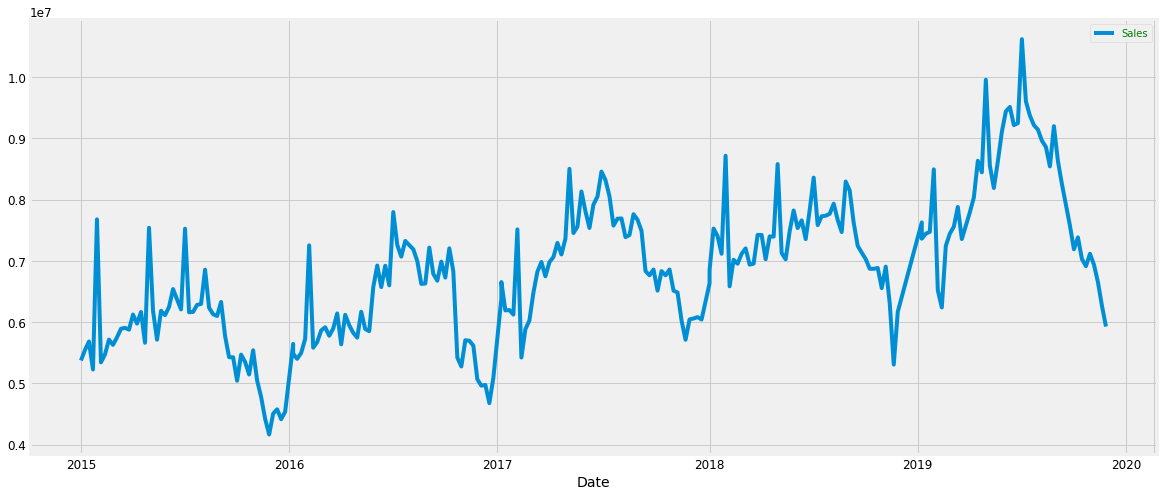

In [9]:
df2 = pd.read_excel('C:/Users/mcter/avocato_conventional_ca2.xlsx')
df2.columns=['Date','Sales']

df2['Date'] = pd.to_datetime(df2['Date'])
df2.set_index('Date', inplace=True)
df2.index = pd.DatetimeIndex(df2.index).to_period('W')
df2.plot()

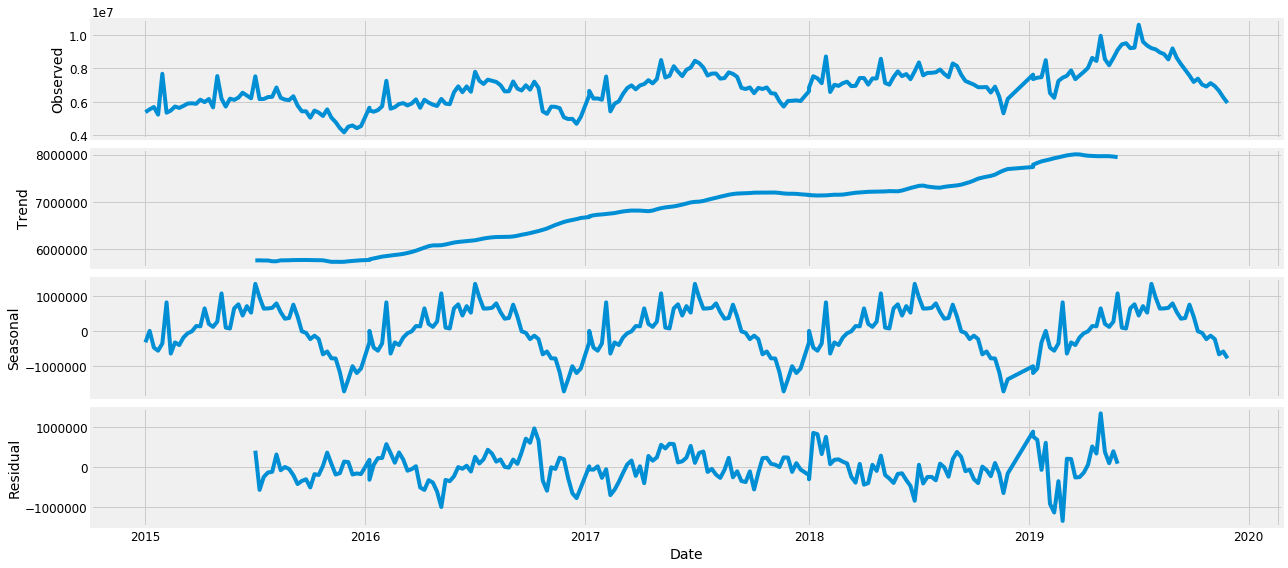

In [10]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df2, model='additive', freq=52) # there are 52 weeks in one year
fig = decomposition.plot()
plt.show()

####### The trend and the residual don't have a huge drop anymore.

In [11]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df2,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}52 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('Error')
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 52)52 - AIC:8656.840484761915
ARIMA(0, 0, 0)x(0, 0, 1, 52)52 - AIC:6782.8258083109
ARIMA(0, 0, 0)x(0, 1, 0, 52)52 - AIC:6080.98539804341
ARIMA(0, 0, 0)x(0, 1, 1, 52)52 - AIC:14125.385451723016
ARIMA(0, 0, 0)x(1, 0, 0, 52)52 - AIC:6031.238841350736
ARIMA(0, 0, 0)x(1, 0, 1, 52)52 - AIC:6000.275629647171
ARIMA(0, 0, 0)x(1, 1, 0, 52)52 - AIC:4538.315337146263
ARIMA(0, 0, 0)x(1, 1, 1, 52)52 - AIC:14162.11267124157
ARIMA(0, 0, 1)x(0, 0, 0, 52)52 - AIC:8442.493531028556
ARIMA(0, 0, 1)x(0, 0, 1, 52)52 - AIC:6667.256370574195
ARIMA(0, 0, 1)x(0, 1, 0, 52)52 - AIC:5976.156612846113
ARIMA(0, 0, 1)x(0, 1, 1, 52)52 - AIC:13984.341234242042
ARIMA(0, 0, 1)x(1, 0, 0, 52)52 - AIC:6710.767750358489
ARIMA(0, 0, 1)x(1, 0, 1, 52)52 - AIC:6645.989424948068
ARIMA(0, 0, 1)x(1, 1, 0, 52)52 - AIC:4466.022923473125
ARIMA(0, 0, 1)x(1, 1, 1, 52)52 - AIC:14060.881046435852
ARIMA(0, 1, 0)x(0, 0, 0, 52)52 - AIC:7390.81938376011
ARIMA(0, 1, 0)x(0, 0, 1, 52)52 - AIC:5833.294056120665
ARIMA(0, 1,

####### Not a huge improvement. Now, the lowest AIC is 4311

In [12]:
# ARIMA(1, 1, 1)x(1, 1, 0, 52)52 - AIC:4311.097822152763
mod = sm.tsa.statespace.SARIMAX(df2,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2368      0.155      1.533      0.125      -0.066       0.540
ma.L1         -0.7037      0.114     -6.160      0.000      -0.928      -0.480
ar.S.L52      -0.3128      0.083     -3.782      0.000      -0.475      -0.151
sigma2      3.658e+11   1.26e-13    2.9e+24      0.000    3.66e+11    3.66e+11


In [13]:
pred = results.get_forecast(steps=4) # next 4 weeks
pred_ci = pred.conf_int()
pred_ci.head(4)

,lower Sales,upper Sales
2019-11-04/2019-11-10,5.171824e+06,7.542646e+06
2019-11-11/2019-11-17,4.505253e+06,7.191988e+06
2019-11-18/2019-11-24,3.640840e+06,6.508298e+06
2019-11-25/2019-12-01,4.264886e+06,7.282426e+06


####### Now the ranges are smaller.
####### If we look for the average values

In [14]:
pred_mean = pred.predicted_mean
pred_mean.head(4)

2019-11-04/2019-11-10    6.357235e+06
2019-11-11/2019-11-17    5.848621e+06
2019-11-18/2019-11-24    5.074569e+06
2019-11-25/2019-12-01    5.773656e+06
Freq: W-SUN, dtype: float64

####### Nice exercise to forecast a seasonal time series with weekly data.